In [ ]:
# Basic imports
from pathlib import Path
import polars as pl
import numpy as np
import matplotlib.pyplot as plt

print("polars:", pl.__version__)

polars: 1.33.0


In [ ]:
# Paths (this notebook is in notebooks/, so root is ..)
ROOT = Path("..")
SILVER = ROOT / "data" / "silver" / "jobs_text.parquet"
GOLD = ROOT / "data" / "gold"

lf = pl.scan_parquet(SILVER)
print("Columns:", lf.collect_schema().names())

# For faster iteration, sample head N; set to None to use all rows
SAMPLE_N = 150_000  # adjust to what your memory allows; or set None
df = (lf.head(SAMPLE_N) if SAMPLE_N else lf).collect()
print("Shape:", df.shape)
df.head(3)

Columns: ['title_lc', 'company', 'location', 'seniority', 'work_type', 'posted_at', 'skills_list', 'text']
Shape: (13420, 8)


title_lc,company,location,seniority,work_type,posted_at,skills_list,text
str,str,str,str,str,datetime[μs],list[str],str
"""senior software engineer - bac…","""Walmart""","""Reston, VA""","""Mid senior""","""Onsite""",2024-01-15 00:00:00,[],"""senior software engineer - bac…"
"""lead software engineer, back e…","""ClickJobs.io""","""Poughkeepsie, NY""","""Mid senior""","""Onsite""",2024-01-14 00:00:00,[],"""lead software engineer, back e…"
"""asset & wealth management- sen…","""Goldman Sachs""","""New York, NY""","""Mid senior""","""Onsite""",2024-01-15 00:00:00,[],"""asset & wealth management- sen…"


In [ ]:
# How many empty/very short texts?
lengths = df.select((pl.col("text").str.len_chars()).alias("len")).to_series()
print("Empty texts:", int((lengths == 0).sum()))
print("Texts <= 30 chars:", int((lengths <= 30).sum()))

# Drop rows with empty text (optional)
df = df.filter(pl.col("text").is_not_null() & (pl.col("text").str.len_chars() > 0))
print("After drop empty:", df.shape)

Empty texts: 0
Texts <= 30 chars: 5328
After drop empty: (13420, 8)


In [ ]:
# Extract corpus
corpus = df["text"].to_list()
print("Corpus size:", len(corpus))

Corpus size: 13420


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Reasonable defaults; tweak as needed
vectorizer = TfidfVectorizer(
    max_features=5000,  # cap vocab size (memory control)
    stop_words="english",  # English stopwords
    min_df=3,  # ignore very rare terms
    max_df=0.7,  # ignore overly common terms
    ngram_range=(1, 2),  # unigrams + bigrams often help
)
X = vectorizer.fit_transform(corpus)

print("TF-IDF shape:", X.shape)  # (n_samples, n_features)

TF-IDF shape: (13420, 2136)


In [ ]:
from sklearn.cluster import KMeans

K = 6  # start with 6; adjust later
kmeans = KMeans(n_clusters=K, random_state=42, n_init="auto")
labels = kmeans.fit_predict(X)

# Attach cluster labels back to Polars DataFrame
df_km = df.with_columns(pl.Series("cluster", labels))
df_km.head(5)

title_lc,company,location,seniority,work_type,posted_at,skills_list,text,cluster
str,str,str,str,str,datetime[μs],list[str],str,i32
"""senior software engineer - bac…","""Walmart""","""Reston, VA""","""Mid senior""","""Onsite""",2024-01-15 00:00:00,[],"""senior software engineer - bac…",0
"""lead software engineer, back e…","""ClickJobs.io""","""Poughkeepsie, NY""","""Mid senior""","""Onsite""",2024-01-14 00:00:00,[],"""lead software engineer, back e…",3
"""asset & wealth management- sen…","""Goldman Sachs""","""New York, NY""","""Mid senior""","""Onsite""",2024-01-15 00:00:00,[],"""asset & wealth management- sen…",0
"""senior software engineer, devo…","""Jobs for Humanity""","""Atlantic City, NJ""","""Mid senior""","""Onsite""",2024-01-14 00:00:00,[],"""senior software engineer, devo…",0
"""principal software engineer, m…","""Aurora""","""San Francisco, CA""","""Mid senior""","""Onsite""",2024-01-14 00:00:00,[],"""principal software engineer, m…",0


In [ ]:
# Cluster sizes
sizes = df_km.group_by("cluster").agg(pl.len().alias("count")).sort("cluster")
sizes

cluster,count
i32,u32
0,6577
1,1311
2,1141
3,1355
4,1120
5,1916


In [ ]:
# Show a couple example titles per cluster
def show_examples(df_pl, cluster_id, n=5):
    out = (
        df_pl.filter(pl.col("cluster") == cluster_id)
        .select(["title_lc", "company", "location"])
        .head(n)
    )
    return out


for c in range(K):
    print(f"\n=== Cluster {c} ===")
    display(show_examples(df_km, c, n=5))


=== Cluster 0 ===


title_lc,company,location
str,str,str
"""senior software engineer - bac…","""Walmart""","""Reston, VA"""
"""asset & wealth management- sen…","""Goldman Sachs""","""New York, NY"""
"""senior software engineer, devo…","""Jobs for Humanity""","""Atlantic City, NJ"""
"""principal software engineer, m…","""Aurora""","""San Francisco, CA"""
"""sr software engineer - azure""","""Butlr""","""Cambridge, MA"""



=== Cluster 1 ===


title_lc,company,location
str,str,str
"""senior software engineer""","""4Catalyzer""","""Guilford, CT"""
"""senior software engineer""","""WooliesX""","""Sydney, New South Wales, Austr…"
"""senior software engineer""","""Index Exchange""","""Toronto, Ontario, Canada"""
"""senior software engineer""","""Matchtech""","""London, England, United Kingdo…"
"""senior software engineer""","""GliaCell Technologies""","""Annapolis Junction, MD"""



=== Cluster 2 ===


title_lc,company,location
str,str,str
"""senior data engineer""","""University of Chicago""","""Chicago, IL"""
"""lead data scientist""","""Dice""","""Atlanta, GA"""
"""senior data engineer, public c…","""Recruiting from Scratch""","""St Louis, MO"""
"""data scientist""","""Belay Technologies""","""Annapolis Junction, MD"""
"""data scientist""","""Futran Solutions""","""Dallas, TX"""



=== Cluster 3 ===


title_lc,company,location
str,str,str
"""lead software engineer, back e…","""ClickJobs.io""","""Poughkeepsie, NY"""
"""lead software engineer""","""The Depository Trust & Clearin…","""Tampa, FL"""
"""principal & lead software engi…","""Jobot""","""Hillsboro, OR"""
"""lead software engineer""","""ESPN""","""New York, NY"""
"""lead software engineer, full s…","""Jobs for Humanity""","""Fredericksburg, VA"""



=== Cluster 4 ===


title_lc,company,location
str,str,str
"""lead data engineer""","""Dice""","""Plano, TX"""
"""data engineer manager""","""Energy Jobline""","""Wolverhampton, England, United…"
"""staff data engineer, fleet ana…","""Tesla""","""Palo Alto, CA"""
"""senior data engineer - azure, …","""Templeton and Partners - Tech …","""London, England, United Kingdo…"
"""lead data engineer, (python, j…","""Dice""","""Philadelphia, PA"""



=== Cluster 5 ===


title_lc,company,location
str,str,str
"""senior financial data analyst""","""The Walt Disney Company""","""Lake Buena Vista, FL"""
"""sr. workforce management data …","""Wisemen Multimedia, LLC""","""Atlanta, GA"""
"""data analyst part time""","""Toyandsons""","""Waterloo, Ontario, Canada"""
"""contractor - epic clarity data…","""Deloitte""","""Mississippi, United States"""
"""vcp design to value project ma…","""GE HealthCare""","""Waukesha, WI"""


In [ ]:
# Get top TF-IDF terms nearest to each cluster centroid
terms = vectorizer.get_feature_names_out()
centers = kmeans.cluster_centers_


def top_terms_for_cluster(cluster_idx, topn=15):
    idxs = np.argsort(centers[cluster_idx])[::-1][:topn]
    return [terms[j] for j in idxs]


for c in range(K):
    print(f"\nCluster {c} top terms:")
    print(top_terms_for_cluster(c, topn=15))


Cluster 0 top terms:
['software', 'software engineer', 'senior', 'senior software', 'embedded', 'embedded software', 'sr', 'sr software', 'senior embedded', 'principal', 'principal software', 'iii', 'engineer iii', 'staff', 'security']

Cluster 1 top terms:
['senior software', 'senior', 'software', 'software engineer', 'engineer stack', 'stack', 'hybrid', 'based', 'onsite', 'iii', 'embedded', 'engineer medical', 'engineer level', 'engineer iot', 'engineer ip']

Cluster 2 top terms:
['data scientist', 'scientist', 'senior data', 'data', 'data engineer', 'senior', 'sr data', 'lead data', 'sr', 'engineer public', 'public company', 'company', 'public', 'lead', 'scientist senior']

Cluster 3 top terms:
['lead software', 'lead', 'engineer end', 'end', 'software engineer', 'software', 'engineer stack', 'stack', 'java', 'senior', 'aws', 'senior software', 'senior lead', 'python', 'end java']

Cluster 4 top terms:
['data engineer', 'data', 'lead data', 'lead', 'sr data', 'sr', 'senior data', '

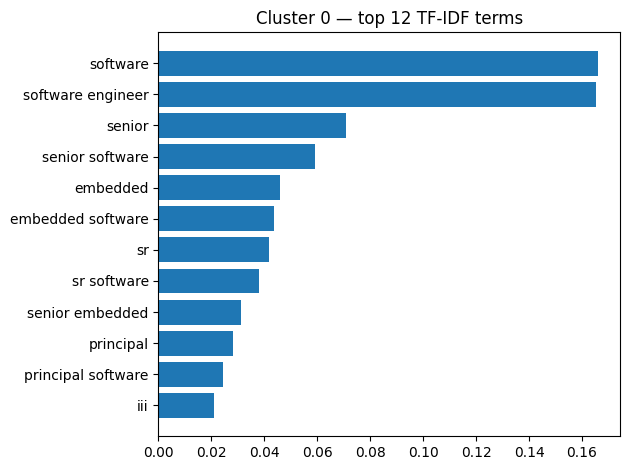

In [ ]:
cluster_to_plot = 0  # change to 1..K-1 to inspect others
topn = 12

idxs = np.argsort(centers[cluster_to_plot])[::-1][:topn]
top_words = [terms[j] for j in idxs]
top_scores = centers[cluster_to_plot][idxs]

plt.figure()
plt.barh(range(topn), top_scores[::-1])  # horizontal bar, reversed for top at top
plt.yticks(range(topn), top_words[::-1])
plt.title(f"Cluster {cluster_to_plot} — top {topn} TF-IDF terms")
plt.tight_layout()
plt.show()

In [ ]:
# Silhouette can be expensive; use a random subset if needed
from sklearn.metrics import silhouette_score
from sklearn.utils import resample

if X.shape[0] > 20000:
    # sample 20k for speed
    sample_size = 20_000
    idx = np.random.default_rng(42).choice(X.shape[0], size=sample_size, replace=False)
    X_s = X[idx]
    y_s = np.array(labels)[idx]
else:
    X_s, y_s = X, labels

score = silhouette_score(X_s, y_s, metric="cosine")
print("Silhouette score (cosine):", round(score, 4))

Silhouette score (cosine): 0.0919


K=4 inertia=10600.21
K=5 inertia=10336.82
K=6 inertia=10066.83
K=7 inertia=10162.51
K=8 inertia=10129.72
K=10 inertia=10081.72


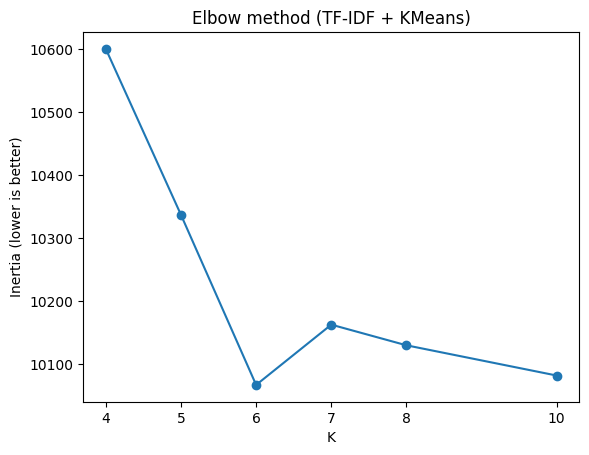

In [ ]:
# This loops multiple K and plots inertia to help choose K
Ks = [4, 5, 6, 7, 8, 10]
inertias = []
for k in Ks:
    m = KMeans(n_clusters=k, random_state=42, n_init="auto")
    m.fit(X)
    inertias.append(m.inertia_)
    print(f"K={k} inertia={m.inertia_:.2f}")

plt.figure()
plt.plot(Ks, inertias, marker="o")
plt.xticks(Ks)
plt.xlabel("K")
plt.ylabel("Inertia (lower is better)")
plt.title("Elbow method (TF-IDF + KMeans)")
plt.show()